In [39]:
#This notebook should point towards the repository's directory
import os
cwd = os.getcwd()
print(cwd)

C:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman


In [53]:
# --- 1. IMPORTS ---
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from trading_utils import *


In [41]:
# --- 2. CONFIGURATION ---

# Define the universe of stocks to analyze
TICKERS = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'META', 'BRK-B', 'LLY', 'V', 'JPM',
    'XOM', 'WMT', 'UNH', 'MA', 'PG', 'JNJ', 'HD', 'COST', 'MRK', 'ABBV', 'CVX',
    'CRM', 'PEP', 'KO', 'ADBE', 'BAC', 'MCD', 'CSCO', 'TMO', 'ACN', 'AVGO',
    'LIN', 'NEE', 'WFC', 'DIS', 'TXN', 'ORCL', 'CMCSA', 'PM', 'RTX', 'HON', 'AMGN',
    'UNP', 'PFE', 'INTC', 'CAT', 'LOW', 'IBM', 'GE', 'GS', 'BA', 'DE', 'NOW',
    'ELV', 'SPGI', 'AXP', 'ISRG', 'AMD', 'BKNG', 'BLK', 'SBUX', 'UPS', 'LMT',
    'PLD', 'C', 'AMT', 'CI', 'GILD', 'TJX', 'PYPL', 'MO', 'T'
]

# Define the In-Sample (Training) and Out-of-Sample (Testing) periods
IN_SAMPLE_START = "2016-01-01"
IN_SAMPLE_END = "2022-12-31"

OUT_OF_SAMPLE_START = "2023-01-01"
OUT_OF_SAMPLE_END = dt.date.today().isoformat()

# Define core strategy parameters
ENTRY_Z = 2.0
EXIT_Z = 0.5
ROLLING_WINDOW = 60

print("--- Configuration Loaded ---")
print(f"Ticker Universe Size: {len(TICKERS)}")
print(f"Training Period: {IN_SAMPLE_START} to {IN_SAMPLE_END}")
print(f"Testing Period: {OUT_OF_SAMPLE_START} to {OUT_OF_SAMPLE_END}")


--- Configuration Loaded ---
Ticker Universe Size: 73
Training Period: 2016-01-01 to 2022-12-31
Testing Period: 2023-01-01 to 2025-06-24



--- Step 1: Finding Correlated Pairs on In-Sample Data ---
Fetching prices from 2016-01-01 to 2022-12-31...


[*********************100%***********************]  73 of 73 completed


 Successfully downloaded and processed data for 73 tickers.

Calculating daily returns and generating correlation heatmap...


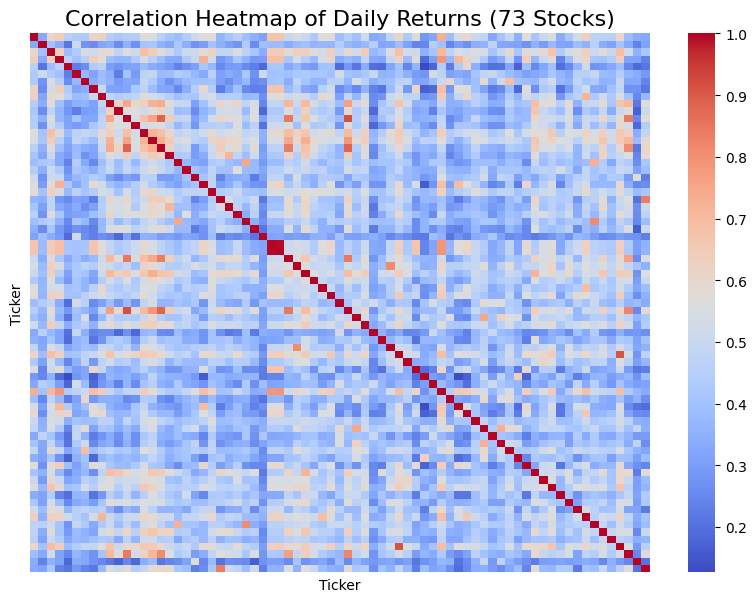


Top 10 Most Correlated Pairs (In-Sample):
Ticker  Ticker
GOOGL   GOOG      0.993940
JPM     BAC       0.921174
MA      V         0.910829
C       BAC       0.886197
JPM     C         0.882379
GS      JPM       0.847854
BAC     GS        0.846453
        WFC       0.839891
GS      C         0.838058
XOM     CVX       0.836672


In [42]:

# ---3. FIND CANDIDATE PAIRS (IN-SAMPLE) ---

print("\n--- Step 1: Finding Correlated Pairs on In-Sample Data ---")

# 1. Fetch price data for the training period
in_sample_prices = fetch_prices(TICKERS, IN_SAMPLE_START, IN_SAMPLE_END)

# 2. Plot heatmap and get a list of all correlated pairs, sorted
if in_sample_prices is not None:
    sorted_pairs = plot_correlation_heatmap(in_sample_prices)

    # 3. Display the top 10 most correlated pairs as our initial candidates
    print("\nTop 10 Most Correlated Pairs (In-Sample):")
    print(sorted_pairs.head(10).to_string())
else:
    print("Could not fetch in-sample data. Halting analysis.")
    sorted_pairs = None # Ensure sorted_pairs exists even on failure



In [43]:
# ---4.SCREEN FOR STATIONARY PAIRS (IN-SAMPLE) ---

print("\n--- Step 2: Screening for Stationary Spreads on In-Sample Data ---")

stationary_pairs_in_sample = []

if sorted_pairs is not None:
    # Use the efficient function to get spreads and ratios for all candidates
    spread_data_dict = calculate_hedge_ratio_and_spread(
        sorted_pairs,
        IN_SAMPLE_START,
        IN_SAMPLE_END
    )
    
    # Loop through the results to perform the stationarity test
    for pair, data in spread_data_dict.items():
        spread_series = data['spread']
        hedge_ratio = data['hedge_ratio']
        
        if check_stationarity(spread_series):
            stationary_pairs_in_sample.append((pair, hedge_ratio))
            
    print(f"\nFound {len(stationary_pairs_in_sample)} stationary pairs from the training period:")
    # Display the final list of pairs we will use for backtesting
    final_pairs_df = pd.DataFrame(stationary_pairs_in_sample, columns=['Pair', 'Hedge Ratio'])
    print(final_pairs_df)

else:
    print("No correlated pairs to analyze.")



--- Step 2: Screening for Stationary Spreads on In-Sample Data ---

Calculating spreads and hedge ratios for all candidate pairs...
Fetching prices from 2016-01-01 to 2022-12-31...


[*********************100%***********************]  73 of 73 completed


 Successfully downloaded and processed data for 73 tickers.


Calculating Spreads: 2628it [00:01, 1358.47it/s]



Found 446 stationary pairs from the training period:
              Pair  Hedge Ratio
0    (GOOGL, GOOG)     0.979675
1          (MA, V)     1.857907
2       (UNH, ELV)     1.075351
3        (HD, LOW)     1.361944
4       (BAC, AXP)     0.217412
..             ...          ...
441       (T, NOW)     0.000624
442      (T, AMZN)     0.001639
443     (NOW, WMT)    17.955564
444    (BKNG, LLY)     1.929200
445     (AMD, WMT)     3.618382

[446 rows x 2 columns]



--- Step 3: Running Portfolio Backtest on Out-of-Sample Data ---
Fetching prices from 2023-01-01 to 2025-06-24...


[*********************100%***********************]  73 of 73 completed


 Successfully downloaded and processed data for 73 tickers.

Running backtest for each pair...


Backtesting Pairs:  21%|████████████████████████▍                                                                                          | 95/446 [00:00<00:02, 158.41it/s]C:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman\trading_utils.py:214: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_daily_pnl[f'{asset1}-{asset2}'] = daily_pnl
C:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman\trading_utils.py:214: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_daily_pnl[f'{asset1}-{asset2}'] = daily_pnl
C:\Us


Out-of-Sample Final Portfolio P&L: 18893.24


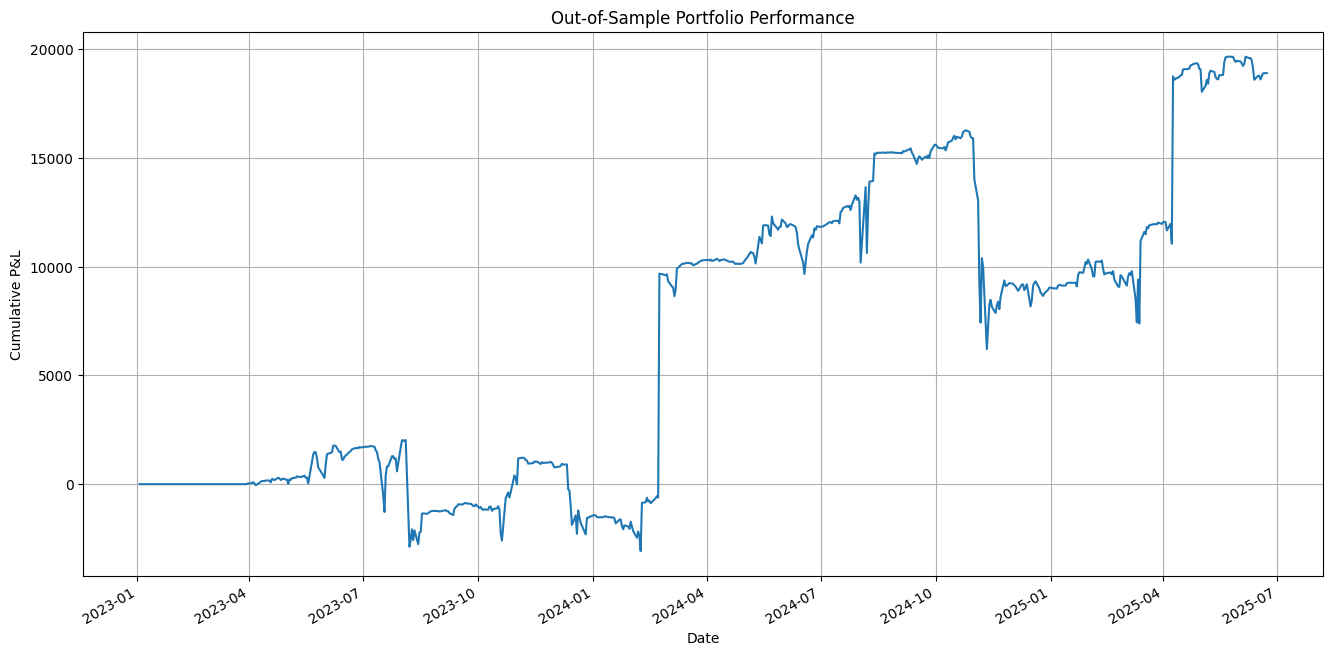

In [44]:

print("\n--- Step 3: Running Portfolio Backtest on Out-of-Sample Data ---")

if not stationary_pairs_in_sample:
    print("No stationary pairs found in training. Cannot run out-of-sample test.")
else:
    # Run the portfolio backtest using the pairs/ratios from the training period
    # on the new, unseen testing data.
    oos_daily_pnl_df = run_portfolio_backtest(
        list_of_pairs=stationary_pairs_in_sample,
        start_date=OUT_OF_SAMPLE_START,
        end_date=OUT_OF_SAMPLE_END,
        entry_z=ENTRY_Z,
        exit_z=EXIT_Z,
        window=ROLLING_WINDOW
    )

    if oos_daily_pnl_df is not None:
        # Calculate the cumulative payoff (equity curve)
        oos_payoff = oos_daily_pnl_df.cumsum()
        
        print(f"\nOut-of-Sample Final Portfolio P&L: {oos_payoff['Total Portfolio'].iloc[-1]:.2f}")
        
        # Plot the out-of-sample equity curve
        plt.figure(figsize=(16, 8))
        oos_payoff['Total Portfolio'].plot(title='Out-of-Sample Portfolio Performance')
        plt.ylabel('Cumulative P&L')
        plt.grid(True)
        plt.show()



--- Step 4: Analyzing Out-of-Sample Performance Details ---

--- Out-of-Sample Performance Summary by Pair ---
(Sorted by Total P&L, worst performers at the top)
            Total P&L  Max Drawdown  Volatility (Daily P&L)
Pair                                                       
BKNG-LLY     -1139.54      -1218.74                   26.71
BKNG-IBM      -705.01      -1505.81                   29.49
NOW-AMT       -332.91       -399.88                    8.11
LLY-PEP       -227.65       -277.09                    4.70
TMO-TJX       -216.98       -320.67                    5.39
TMO-ORCL      -183.63       -273.27                   12.10
LMT-LLY       -141.88       -210.00                    3.98
UNH-ELV       -132.76       -165.17                    4.15
LMT-MRK       -130.71       -178.19                    4.25
COST-ORCL     -112.85       -301.23                   11.56
COST-LOW       -93.51       -171.69                    3.59
TMO-AAPL       -88.25       -117.38                    3.

C:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman\trading_utils.py:280: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pnl = daily_pnl_df['Total Portfolio'].resample('M').sum()


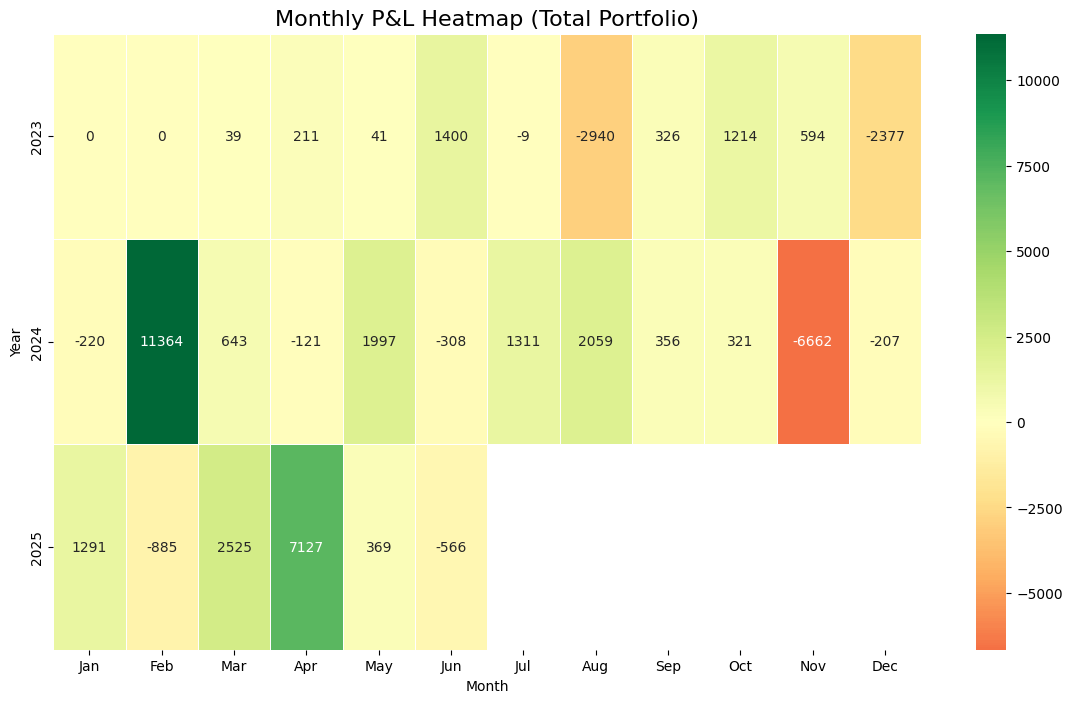

In [45]:
# --- 5. ANALYZE OUT-OF-SAMPLE PERFORMANCE ---

print("\n--- Step 4: Analyzing Out-of-Sample Performance Details ---")

if 'oos_daily_pnl_df' in locals() and oos_daily_pnl_df is not None:
    
    # 1. Analyze the performance of each individual pair on the test data
    oos_performance_summary = analyze_pair_performance(oos_daily_pnl_df)
    
    print("\n--- Out-of-Sample Performance Summary by Pair ---")
    print("(Sorted by Total P&L, worst performers at the top)")
    print(oos_performance_summary.to_string(float_format="%.2f"))

    # 2. Generate the monthly P&L heatmap for the out-of-sample period
    plot_pnl_heatmap(
        oos_daily_pnl_df
    )
    
else:
    print("No out-of-sample data to analyze.")



--- Step 5: Optimizing Portfolio Based on In-Sample Performance ---
Running backtest on IN-SAMPLE data to select profitable pairs...
Fetching prices from 2016-01-01 to 2022-12-31...


[*********************100%***********************]  73 of 73 completed


 Successfully downloaded and processed data for 73 tickers.

Running backtest for each pair...


Backtesting Pairs:  22%|█████████████████████████▌                                                                                        | 100/446 [00:00<00:02, 160.78it/s]C:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman\trading_utils.py:214: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_daily_pnl[f'{asset1}-{asset2}'] = daily_pnl
C:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman\trading_utils.py:214: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_daily_pnl[f'{asset1}-{asset2}'] = daily_pnl
C:\Us


Identified 367 profitable pairs during the IN-SAMPLE period.

Running backtest on OUT-OF-SAMPLE data with the optimized portfolio...
Fetching prices from 2023-01-01 to 2025-06-24...


[*********************100%***********************]  73 of 73 completed


 Successfully downloaded and processed data for 73 tickers.

Running backtest for each pair...


Backtesting Pairs:  25%|████████████████████████████▏                                                                                      | 90/367 [00:00<00:02, 111.03it/s]C:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman\trading_utils.py:214: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_daily_pnl[f'{asset1}-{asset2}'] = daily_pnl
C:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman\trading_utils.py:214: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_daily_pnl[f'{asset1}-{asset2}'] = daily_pnl
C:\Us

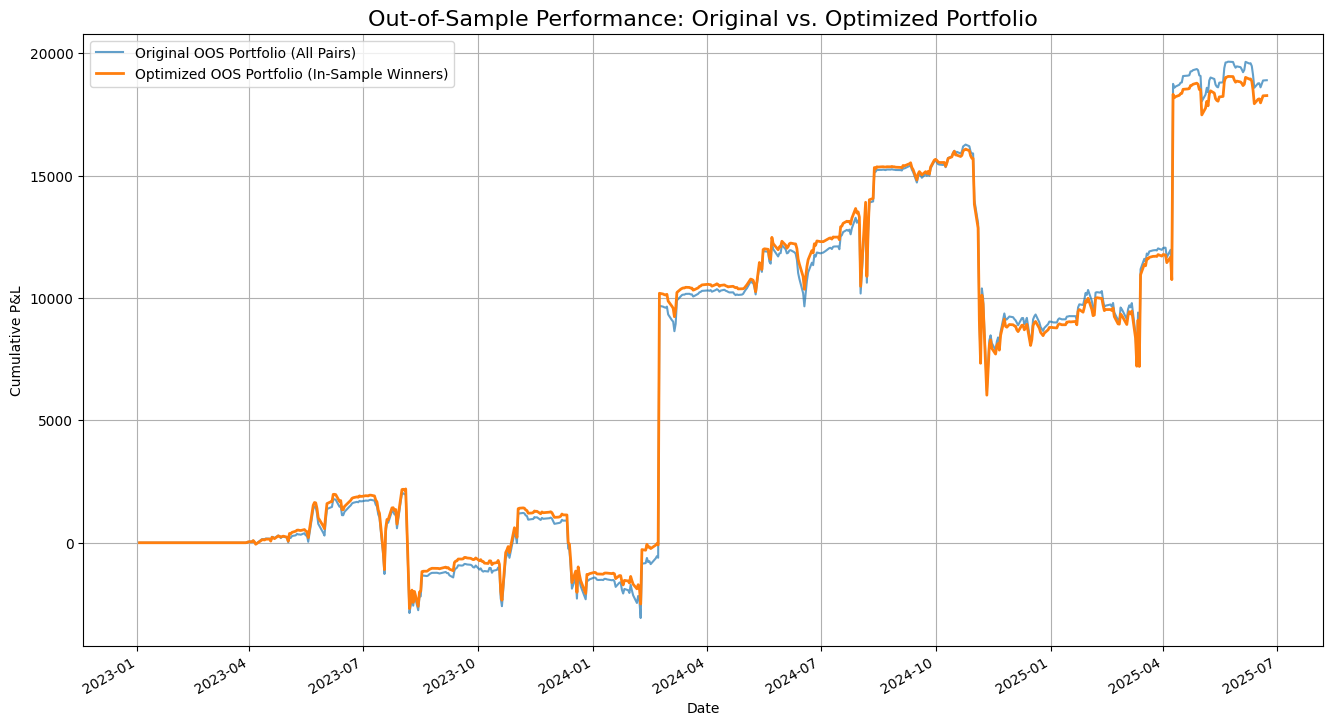

C:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman\trading_utils.py:280: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pnl = daily_pnl_df['Total Portfolio'].resample('M').sum()


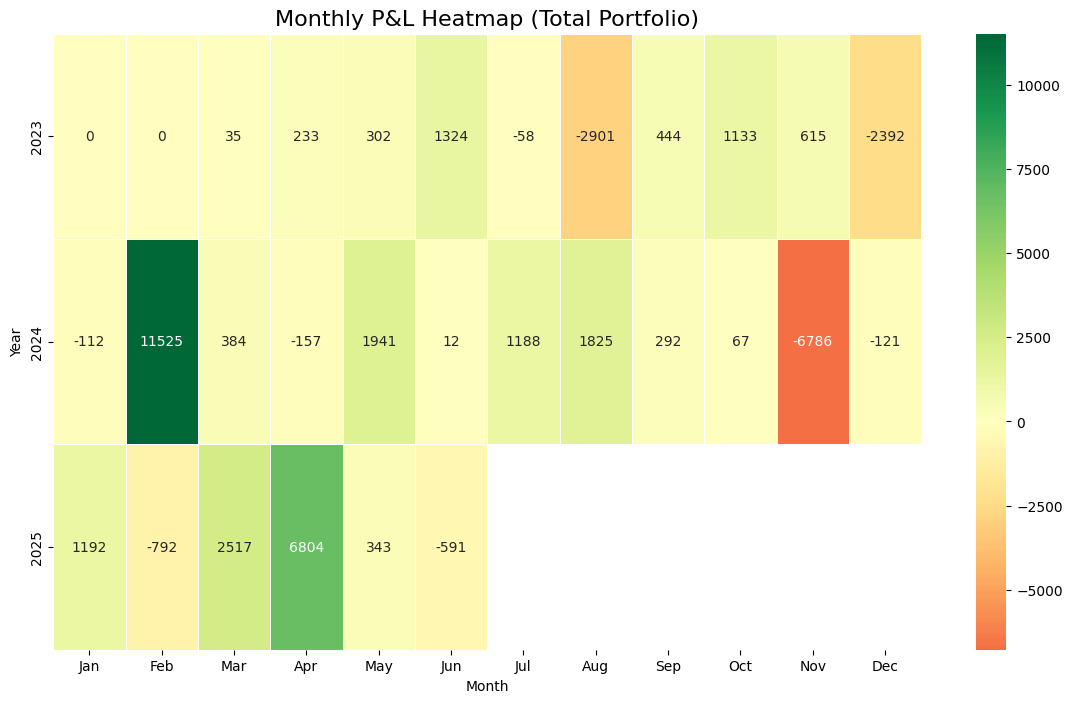

In [46]:
print("\n--- Step 5: Optimizing Portfolio Based on In-Sample Performance ---")

if 'stationary_pairs_in_sample' in locals() and stationary_pairs_in_sample:
    # 1. Run a backtest on the IN-SAMPLE period to find the "winners"
    print("Running backtest on IN-SAMPLE data to select profitable pairs...")
    in_sample_daily_pnl = run_portfolio_backtest(
        list_of_pairs=stationary_pairs_in_sample,
        start_date=IN_SAMPLE_START,
        end_date=IN_SAMPLE_END
    )

    # 2. Analyze performance and select pairs that were profitable in-sample
    in_sample_summary = analyze_pair_performance(in_sample_daily_pnl)
    profitable_in_sample_pairs = in_sample_summary[in_sample_summary['Total P&L'] > 0]
    optimized_pair_names = profitable_in_sample_pairs.index.tolist()

    print(f"\nIdentified {len(optimized_pair_names)} profitable pairs during the IN-SAMPLE period.")

    # 3. Create the new, optimized list of pairs to test out-of-sample
    original_pairs_map = {f'{p[0][0]}-{p[0][1]}': p for p in stationary_pairs_in_sample}
    optimized_list_of_pairs = [original_pairs_map[name] for name in optimized_pair_names if name in original_pairs_map]

    # 4. Run a new backtest on the OUT-OF-SAMPLE data using ONLY the optimized list
    if optimized_list_of_pairs:
        print("\nRunning backtest on OUT-OF-SAMPLE data with the optimized portfolio...")
        optimized_oos_daily_pnl = run_portfolio_backtest(
            list_of_pairs=optimized_list_of_pairs,
            start_date=OUT_OF_SAMPLE_START,
            end_date=OUT_OF_SAMPLE_END
        )

        # 5. Compare the OOS performance of the Original vs. Optimized portfolios
        if optimized_oos_daily_pnl is not None and 'oos_daily_pnl_df' in locals():
            original_oos_payoff = oos_daily_pnl_df['Total Portfolio'].cumsum()
            optimized_oos_payoff = optimized_oos_daily_pnl['Total Portfolio'].cumsum()

            plt.figure(figsize=(16, 9))
            original_oos_payoff.plot(label='Original OOS Portfolio (All Pairs)', legend=True, alpha=0.7)
            optimized_oos_payoff.plot(label='Optimized OOS Portfolio (In-Sample Winners)', legend=True, linewidth=2)
            plt.title('Out-of-Sample Performance: Original vs. Optimized Portfolio', fontsize=16)
            plt.ylabel('Cumulative P&L')
            plt.grid(True)
            plt.show()

            plot_pnl_heatmap(
                optimized_oos_daily_pnl,
            )
    else:
        print("No pairs were profitable during the in-sample period. Cannot create optimized portfolio.")

else:
    print("No stationary pairs to analyze.")



--- Step 6: Analyzing Top P&L Contributors by Pair ---


C:\Users\user\AppData\Local\Temp\ipykernel_7360\124830587.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_profits.loc['Others'] = {'Total P&L': others_profit_sum, 'Max Drawdown': 0, 'Volatility (Daily P&L)': 0}
C:\Users\user\AppData\Local\Temp\ipykernel_7360\124830587.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_losses.loc['Others'] = {'Total P&L': others_loss_sum, 'Max Drawdown': 0, 'Volatility (Daily P&L)': 0}


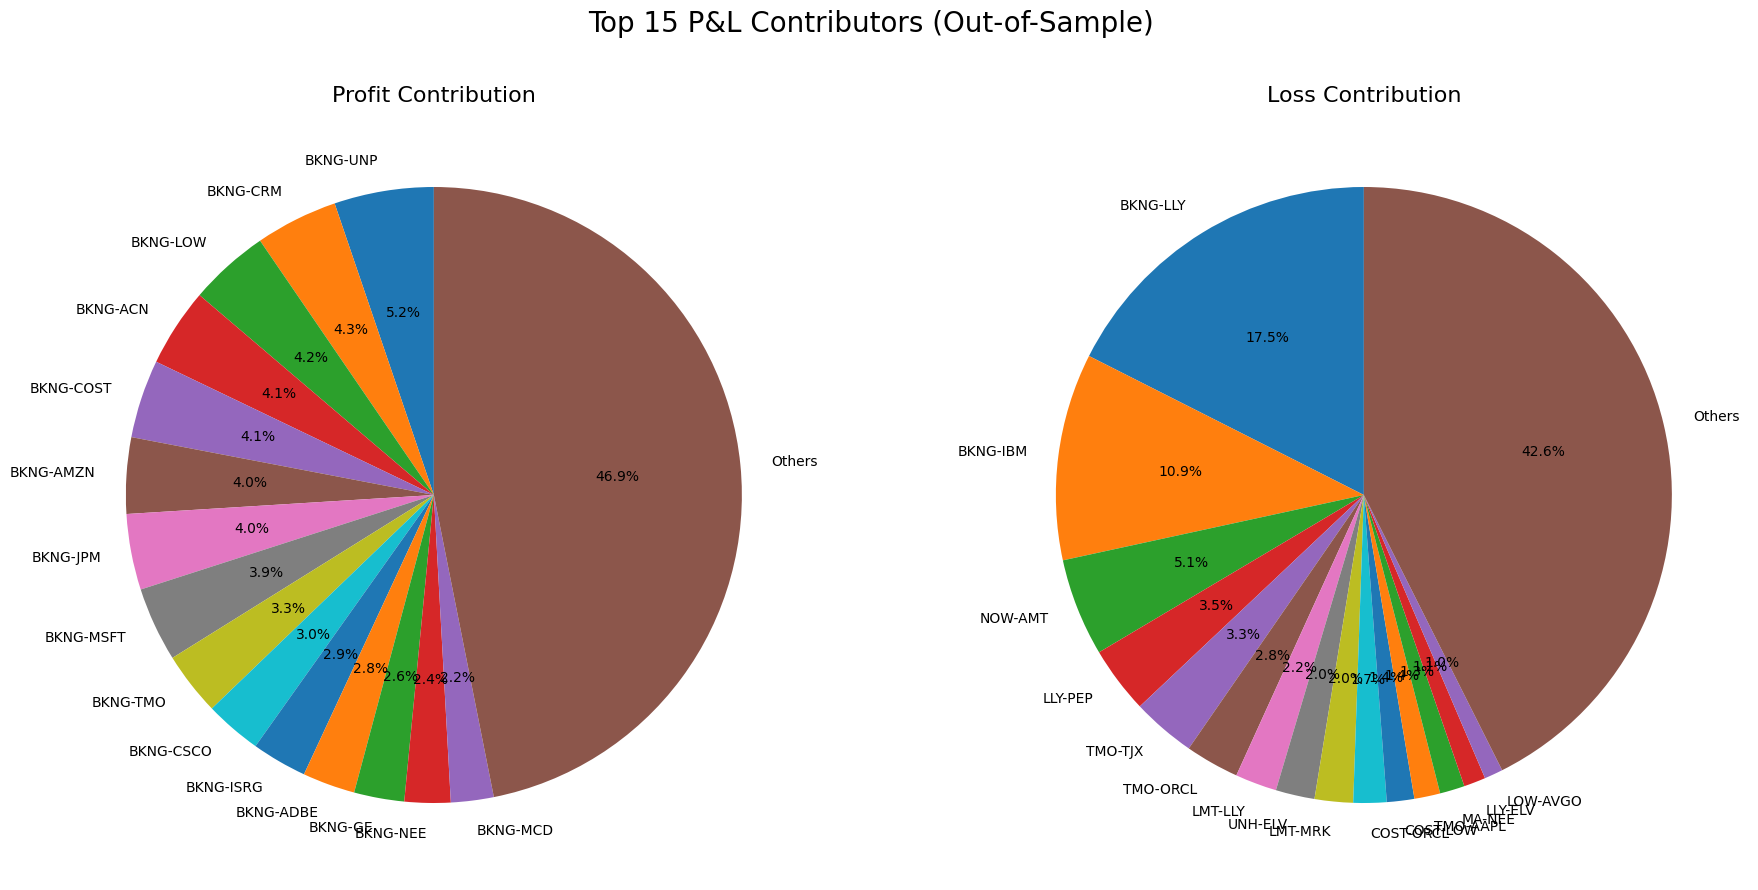

In [47]:
# --- CELL 7: VISUALIZE TOP P&L CONTRIBUTORS (OUT-OF-SAMPLE) ---

print("\n--- Step 6: Analyzing Top P&L Contributors by Pair ---")

if 'oos_performance_summary' in locals() and oos_performance_summary is not None:
    
    # 1. Separate profitable pairs from unprofitable ones
    profits = oos_performance_summary[oos_performance_summary['Total P&L'] > 0].copy()
    losses = oos_performance_summary[oos_performance_summary['Total P&L'] < 0].copy()

    # --- Prepare data for the PROFIT pie chart (Top 15 + Others) ---
    if len(profits) > 15:
        profits.sort_values(by='Total P&L', ascending=False, inplace=True)
        top_profits = profits.head(15)
        others_profit_sum = profits.iloc[15:]['Total P&L'].sum()
        # FIX: Provide a complete row to avoid ValueError
        top_profits.loc['Others'] = {'Total P&L': others_profit_sum, 'Max Drawdown': 0, 'Volatility (Daily P&L)': 0}
        profit_values = top_profits['Total P&L']
    else:
        profit_values = profits['Total P&L']

    # --- Prepare data for the LOSS pie chart (Top 15 + Others) ---
    if len(losses) > 15:
        losses.sort_values(by='Total P&L', ascending=True, inplace=True)
        top_losses = losses.head(15)
        others_loss_sum = losses.iloc[15:]['Total P&L'].sum()
        # FIX: Provide a complete row to avoid ValueError
        top_losses.loc['Others'] = {'Total P&L': others_loss_sum, 'Max Drawdown': 0, 'Volatility (Daily P&L)': 0}
        loss_values = top_losses['Total P&L'].abs()
    else:
        loss_values = losses['Total P&L'].abs()

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    fig.suptitle('Top 15 P&L Contributors (Out-of-Sample)', fontsize=20)

    # Plot PROFIT contribution
    if not profit_values.empty:
        ax1.pie(profit_values, labels=profit_values.index, autopct='%1.1f%%', startangle=90)
        ax1.set_title('Profit Contribution', fontsize=16)
    else:
        ax1.text(0.5, 0.5, 'No Profitable Pairs', horizontalalignment='center', verticalalignment='center')
        ax1.set_title('Profit Contribution', fontsize=16)
        ax1.axis('off')

    # Plot LOSS contribution
    if not loss_values.empty:
        ax2.pie(loss_values, labels=loss_values.index, autopct='%1.1f%%', startangle=90)
        ax2.set_title('Loss Contribution', fontsize=16)
    else:
        ax2.text(0.5, 0.5, 'No Losing Pairs', horizontalalignment='center', verticalalignment='center')
        ax2.set_title('Loss Contribution', fontsize=16)
        ax2.axis('off')

    plt.show()

else:
    print("No out-of-sample performance data to analyze.")


--- Running Risk-Adjusted Backtest (Out-of-Sample) ---
Fetching prices from 2023-01-01 to 2025-06-24...


[*********************100%***********************]  73 of 73 completed


 Successfully downloaded and processed data for 73 tickers.

Running risk-adjusted backtest for each pair...


Backtesting Pairs:  19%|██████████████████████▏                                                                                            | 86/446 [00:00<00:02, 128.38it/s]C:\Users\user\AppData\Local\Temp\ipykernel_7360\86763208.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_daily_pnl[f'{asset1}-{asset2}'] = normalized_pnl
Backtesting Pairs:  23%|█████████████████████████▊                                                                                        | 101/446 [00:00<00:02, 132.98it/s]C:\Users\user\AppData\Local\Temp\ipykernel_7360\86763208.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

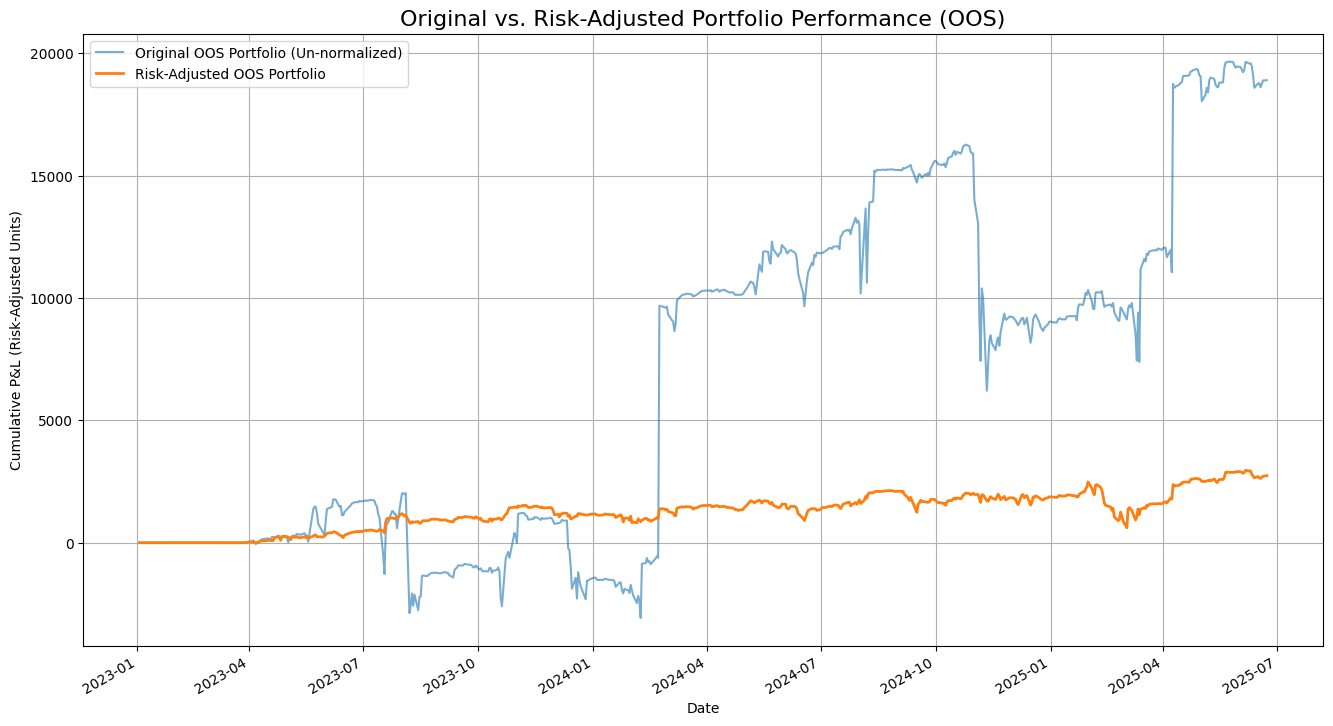

C:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman\trading_utils.py:280: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pnl = daily_pnl_df['Total Portfolio'].resample('M').sum()


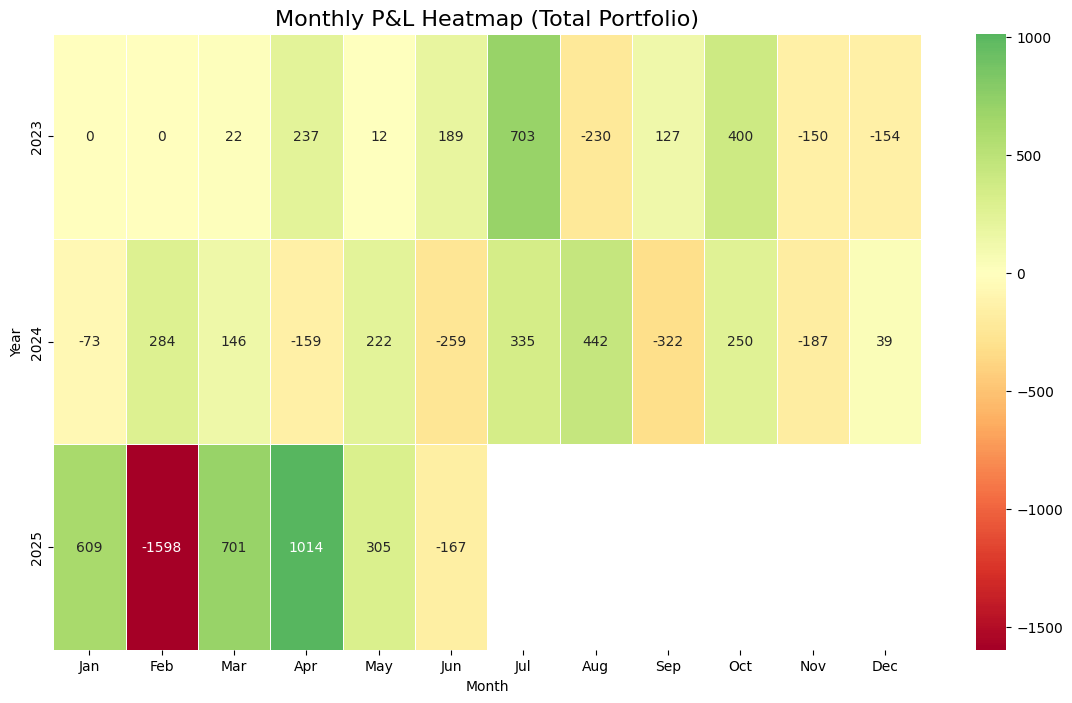

In [59]:
def run_risk_adjusted_backtest(list_of_pairs, start_date, end_date, entry_z=2.0, exit_z=0.5, window=60, volatility_target=1):
    """
    Runs a backtest where each pair's P&L is normalized by its volatility
    to ensure equal risk contribution to the total portfolio.

    Args:
        list_of_pairs (list): List of ((ASSET1, ASSET2), HEDGE_RATIO).
        start_date, end_date: Date ranges for the backtest.
        entry_z, exit_z, window: Strategy parameters.
        volatility_target (float): An arbitrary target to scale the final P&L.

    Returns:
        pd.DataFrame: A DataFrame with the risk-adjusted P&L for each pair and the total portfolio.
    """
    all_tickers = list(set(ticker for pair_info in list_of_pairs for ticker in pair_info[0]))
    prices_df = fetch_prices(all_tickers, start_date, end_date)
    if prices_df is None: return None

    portfolio_daily_pnl = pd.DataFrame(index=prices_df.index)

    print("\nRunning risk-adjusted backtest for each pair...")
    for pair_info in tqdm(list_of_pairs, desc="Backtesting Pairs"):
        pair, hedge_ratio = pair_info
        asset1, asset2 = pair

        if asset1 not in prices_df.columns or asset2 not in prices_df.columns:
            continue

        # --- Standard P&L Calculation ---
        spread = prices_df[asset1] - hedge_ratio * prices_df[asset2]
        trading_df = generate_trading_signals(spread, entry_z, exit_z, window)
        daily_pnl = trading_df['position'].shift(1) * trading_df['spread'].diff()

        # --- Volatility Normalization ---
        # 1. Calculate the standard deviation of the pair's daily P&L
        pnl_volatility = daily_pnl.std()

        # 2. Normalize the daily P&L by this volatility.
        #    This creates a "risk-unit" P&L stream.
        if pnl_volatility > 0:
            # We scale it by a target to make the final P&L numbers more intuitive
            normalized_pnl = (daily_pnl / pnl_volatility) * volatility_target
        else:
            normalized_pnl = 0 # No trades or no volatility

        portfolio_daily_pnl[f'{asset1}-{asset2}'] = normalized_pnl

    portfolio_daily_pnl = portfolio_daily_pnl.fillna(0)
    portfolio_daily_pnl['Total Portfolio'] = portfolio_daily_pnl.sum(axis=1)

    return portfolio_daily_pnl

print("\n--- Running Risk-Adjusted Backtest (Out-of-Sample) ---")

if 'stationary_pairs_in_sample' in locals() and stationary_pairs_in_sample:
    # 1. Run the new risk-adjusted backtest
    risk_adjusted_pnl_df = run_risk_adjusted_backtest(
        list_of_pairs=stationary_pairs_in_sample,
        start_date=OUT_OF_SAMPLE_START,
        end_date=OUT_OF_SAMPLE_END
    )

    if risk_adjusted_pnl_df is not None:
        # 2. Get the equity curves for comparison
        original_payoff = oos_daily_pnl_df['Total Portfolio'].cumsum()
        risk_adjusted_payoff = risk_adjusted_pnl_df['Total Portfolio'].cumsum()

        # 3. Plot the comparison
        plt.figure(figsize=(16, 9))
        original_payoff.plot(label='Original OOS Portfolio (Un-normalized)', legend=True, alpha=0.6)
        risk_adjusted_payoff.plot(label='Risk-Adjusted OOS Portfolio', legend=True, linewidth=2)
        
        plt.title('Original vs. Risk-Adjusted Portfolio Performance (OOS)', fontsize=16)
        plt.ylabel('Cumulative P&L (Risk-Adjusted Units)')
        plt.grid(True)
        plt.show()

        # 4. Generate the heatmap for the new, smoother portfolio
        plot_pnl_heatmap(
            risk_adjusted_pnl_df,
        )
else:
    print("No stationary pairs to analyze.")


--- Step 8: Simulating with Limited Capital ---
Fetching prices from 2023-01-01 to 2025-06-24...


[*********************100%***********************]  73 of 73 completed


 Successfully downloaded and processed data for 73 tickers.

Running capital-constrained backtest...


Backtesting Pairs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 446/446 [00:06<00:00, 67.89it/s]


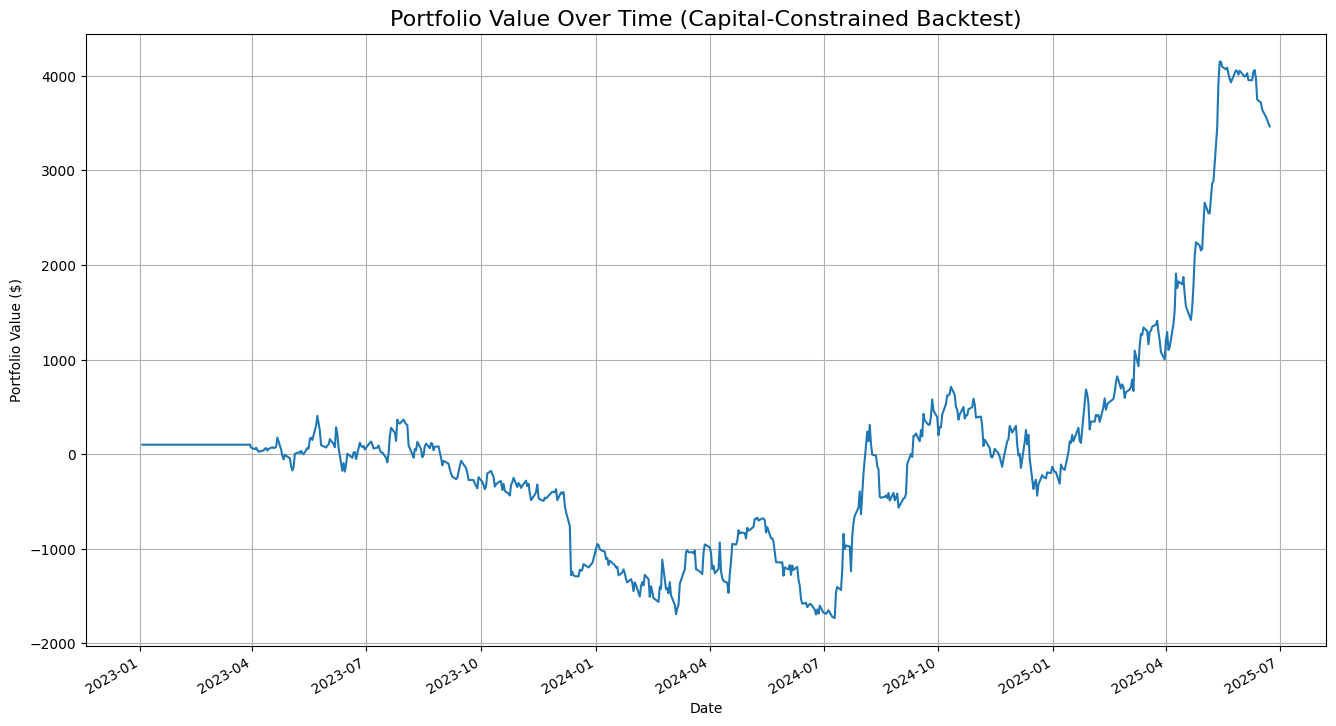

Starting Capital: $100.00
Ending Portfolio Value: $3,464.89
Total Profit: $3,364.89


In [63]:
def run_capital_constrained_backtest(list_of_pairs, start_date, end_date, initial_capital, trade_size, entry_z=2.0, exit_z=0.5, window=60):
    """
    Runs a backtest simulating a portfolio with a starting capital and fixed
    notional value for each trade.

    Args:
        list_of_pairs (list): List of ((ASSET1, ASSET2), HEDGE_RATIO).
        start_date, end_date: Date ranges for the backtest.
        initial_capital (float): The starting capital for the portfolio.
        trade_size (float): The fixed notional value to allocate to each side of a trade.
        entry_z, exit_z, window: Strategy parameters.

    Returns:
        pd.DataFrame: A DataFrame with the final portfolio equity curve.
    """
    all_tickers = list(set(ticker for pair_info in list_of_pairs for ticker in pair_info[0]))
    prices_df = fetch_prices(all_tickers, start_date, end_date)
    if prices_df is None: return None

    portfolio_daily_pnl = pd.DataFrame(index=prices_df.index, data=0.0, columns=range(len(list_of_pairs)))

    print("\nRunning capital-constrained backtest...")
    for i, pair_info in enumerate(tqdm(list_of_pairs, desc="Backtesting Pairs")):
        pair, hedge_ratio = pair_info
        asset1, asset2 = pair

        if asset1 not in prices_df.columns or asset2 not in prices_df.columns: continue

        # Generate signals
        spread = prices_df[asset1] - hedge_ratio * prices_df[asset2]
        trading_df = generate_trading_signals(spread, entry_z, exit_z, window)
        
        # Determine trade entry points
        signals = trading_df['position'].diff().fillna(0)
        entry_long = (signals == 1)
        entry_short = (signals == -1)

        # Calculate number of shares at each entry point based on trade_size
        shares1 = pd.Series(index=prices_df.index, data=0.0)
        shares2 = pd.Series(index=prices_df.index, data=0.0)
        
        shares1[entry_long] = trade_size / prices_df[asset1][entry_long]
        shares2[entry_long] = - (trade_size * hedge_ratio) / prices_df[asset2][entry_long]

        shares1[entry_short] = -trade_size / prices_df[asset1][entry_short]
        shares2[entry_short] = (trade_size * hedge_ratio) / prices_df[asset2][entry_short]
        
        # Propagate share counts until exit signal
        position_active = (trading_df['position'] != 0)
        shares1 = shares1.where(position_active).ffill().fillna(0)
        shares2 = shares2.where(position_active).ffill().fillna(0)

        # Calculate P&L based on actual share price changes
        pnl1 = shares1.shift(1) * prices_df[asset1].diff()
        pnl2 = shares2.shift(1) * prices_df[asset2].diff()
        
        portfolio_daily_pnl[i] = pnl1 + pnl2

    # Calculate total portfolio daily P&L and final equity curve
    total_daily_pnl = portfolio_daily_pnl.sum(axis=1)
    equity_curve = initial_capital + total_daily_pnl.cumsum()
    
    return pd.DataFrame({'Portfolio Value': equity_curve})


print("\n--- Step 8: Simulating with Limited Capital ---")

# Define portfolio capital constraints
INITIAL_CAPITAL = 100  # Starting with $100,000
TRADE_SIZE = 100       # Each trade will have a notional value of $10,000 per leg

if 'stationary_pairs_in_sample' in locals() and stationary_pairs_in_sample:
    
    # 1. Run the new capital-constrained backtest
    capital_constrained_results = run_capital_constrained_backtest(
        list_of_pairs=stationary_pairs_in_sample,
        start_date=OUT_OF_SAMPLE_START,
        end_date=OUT_OF_SAMPLE_END,
        initial_capital=INITIAL_CAPITAL,
        trade_size=TRADE_SIZE
    )

    if capital_constrained_results is not None:
        # 2. Plot the portfolio value over time
        plt.figure(figsize=(16, 9))
        capital_constrained_results['Portfolio Value'].plot()
        
        plt.title('Portfolio Value Over Time (Capital-Constrained Backtest)', fontsize=16)
        plt.ylabel('Portfolio Value ($)')
        plt.xlabel('Date')
        plt.grid(True)
        # Use a log scale on the y-axis to better visualize percentage changes
        # plt.yscale('log') 
        plt.show()

        # Print the final stats
        final_value = capital_constrained_results['Portfolio Value'].iloc[-1]
        total_profit = final_value - INITIAL_CAPITAL
        print(f"Starting Capital: ${INITIAL_CAPITAL:,.2f}")
        print(f"Ending Portfolio Value: ${final_value:,.2f}")
        print(f"Total Profit: ${total_profit:,.2f}")

else:
    print("No stationary pairs to analyze.")







